In [1]:
# import JAX to use
import jax
import jax.numpy as jnp
from jax import grad, vmap, random
from sklearn.datasets import fetch_openml
import pickle
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

1. Implement a dense feedforward neural network from scratch.

   The implementation must be flexible with respect to:
   - The input and output dimensions.
   - The number of hidden layers.
   - The number of neurons per hidden layer.
   - The activation functions used.

   This implementation will be used for the following two questions.

   Choose a suitable initialization for the network parameters.

In [2]:
# We start with a function that initializes the network parameters.
def init_net_params(layer_widths, key):
    """
    Initialize the network parameters.
    """
    params = []
    keys = random.split(key, len(layer_widths) - 1)

    for i, (n_in, n_out) in enumerate(zip(layer_widths[:-1], layer_widths[1:])):
        w_key = keys[i]
        scale = jnp.sqrt(2.0 / n_in) # xavier initialization
        w = random.normal(w_key, shape=(n_in, n_out)) * scale
        b = jnp.zeros((n_out,))
        params.append({'w': w, 'b': b})

    return params


In [3]:
# Next, we define a forward pass function that computes the output of the network for a given input.
def forward(params, x, activation):
    """
    Forward pass of the network.
    """

    activations = {
        'relu': jax.nn.relu,
        'sigmoid': jax.nn.sigmoid,
        'tanh': jax.nn.tanh,
        'softmax': jax.nn.softmax
    }
    activation = activations[activation]

    for layer in params[:-1]:
        x = x @ layer['w'] + layer['b']
        x = activation(x)

    # output layer, no activation function
    final_layer = params[-1]
    return jnp.dot(x, final_layer['w']) + final_layer['b']

def get_batches(x, y, batch_size=256):
    """
    Returns a list of tuples (x_batch, y_batch), each of size batch_size
    (last batch may be smaller).
    """
    n = x.shape[0]
    
    # Make key
    key = random.PRNGKey(0)
    perm = jax.random.permutation(key, n)
    x_shuffled = x[perm]
    y_shuffled = y[perm]

    batches = []
    for i in range(0, n, batch_size):
        x_batch = x_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        batches.append((x_batch, y_batch))

    return batches

def get_splits(x, y, train=0.8, classification=True):
    """
    This return a jax array of the training, validation, and test splits
    """
    n = x.shape[0]
    x = jnp.array(x) / 255.0 if classification else x
    y = jnp.array(y)
    # Calculate split indices (as integers)
    train_end = int(train * n)
    test_end = train_end + int((1-train)) * n
    
    # Split the data
    x_train = x[:train_end]
    y_train = y[:train_end]
    
    x_test = x[test_end:]
    y_test = y[test_end:]
    
    return x_train, y_train, x_test, y_test

def get_kfolds(x, y, k=5):
    """
    Generate k-fold cross-validation splits.
    """
    n = x.shape[0]

    fold_size = n // k
    folds = []

    for i in range(k):
        # Validation fold indices
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        
        # Validation set
        x_val = x[val_start:val_end]
        y_val = y[val_start:val_end]
        
        # Training set (everything except validation fold)
        x_train = jnp.concatenate([x[:val_start], x[val_end:]], axis=0)
        y_train = jnp.concatenate([y[:val_start], y[val_end:]], axis=0)
        
        folds.append((x_train, y_train, x_val, y_val))
    
    return folds

In [4]:
# Next, we define the MSE loss function, we can have other loss functions
def mse_loss(params, x, y, activation):
    """
    MSE loss function for the network.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    preds = batched_forward(params, x, activation)
    return jnp.mean((preds - y) ** 2)

def class_loss(params, x, y, activation):
    """
    Classification cross-entroy loss function
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    nll = -log_probs[jnp.arange(y.shape[0]), y]
    loss = jnp.mean(nll)

    return loss

def evaluate_model(params, x, y, activation, classification):
    """
    Evaluate model on a dataset and return accuracy and loss.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    if classification:
        preds = jnp.argmax(logits, axis=1)
        
        accuracy = jnp.mean(preds == y)
        loss = class_loss(params, x, y, activation)
        
        return accuracy, loss
    else:
        loss = jnp.mean((logits - y) ** 2)
        return loss, loss # we return the loss twice for consistency

In [5]:
# We now define an update function that updates the network parameters.
def update(params, x, y, activation, lr, classification):
    """
    Update function for the network parameters (basic gradient descent).
    """
    loss_fn = class_loss if classification else mse_loss
    grads = grad(loss_fn)(params, x, y, activation)
    new_params = jax.tree.map(lambda p, g: p - lr * g, params, grads)
    return new_params

# After training, save the parameters
def save_params(params, filename='assets/params.pkl'):
    """Save model parameters."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'wb') as f:
        pickle.dump(params, f)
    print(f"Parameters saved to {filename}")

def load_params(filename='assets/params.pkl'):
    """Load model parameters."""
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    print(f"Parameters loaded from {filename}")
    return params

2. Consider a standard benchmark dataset for classification: train a neural network to classify handwritten digits into the ten classes 0, 1,..., 9. As input for your model, use flattened vector representations of the MNIST images

   (a) For this multiclass classification task, train your neural network with cross-entropy loss and mini-batch gradient descent. Vary the neural network architecture (layers, neurons per layer, activation functions) and training hyperparameters (learning rate, batch size, epochs). Use grid search with k-fold cross-validation (e.g., k = 5) to select promising hyperparameters. Report the accuracy and learning curves for the best model.

In [6]:
mnist = fetch_openml('mnist_784')
print(f"We have {mnist.data.shape[0]} images")
print(f"Each image has {mnist.data.shape[1]} pixels (features)")

We have 70000 images
Each image has 784 pixels (features)


In [7]:
def train_model_kfold(x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=5, classification=True):
    """
    Train the model using kfold cross-validation.
    """
    folds = get_kfolds(x_train, y_train, k=k)
    fold_results =[]

    for fold_idx, (x_train_fold, y_train_fold, x_val_fold, y_val_fold) in enumerate(folds):
        key = random.PRNGKey(42 + fold_idx) # we use a different key for each fold
        params = init_net_params(layer_widths, key)
        best_acc = -1
        best_loss = np.inf
        best_params = None
        step = 0

        fold_history = {
            'train_acc': [],
            'val_acc': [],
            'train_loss': [],
            'val_loss': []
        }

        for epoch in range(epochs):
            batches = get_batches(x_train_fold, y_train_fold, batch_size=batch_size)

            for x_batch, y_batch in batches:
                params = update(params, x_batch, y_batch, activation, lr, classification=classification)
            
            train_acc, train_loss = evaluate_model(params, x_train_fold, y_train_fold, activation, classification=classification)
            val_acc, val_loss = evaluate_model(params, x_val_fold, y_val_fold, activation, classification=classification)

            if classification:
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_loss = val_loss
                    best_params = params
                    step = 0
                else:
                    step +=1
            else:
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = params
                    step = 0
                else:
                    step +=1

            fold_history['train_acc'].append(float(train_acc))
            fold_history['val_acc'].append(float(val_acc))
            fold_history['train_loss'].append(float(train_loss))
            fold_history['val_loss'].append(float(val_loss))

            if step > 10:
                print(f"Early stopping at epoch {epoch}")
                break
            
            if epoch % 50 == 0:
                if classification:
                    print(f"Fold {fold_idx+1}, Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
                else:
                    print(f"Fold {fold_idx+1}, Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        final_train_acc, final_train_loss = evaluate_model(best_params, x_train_fold, y_train_fold, activation, classification=classification)
        final_val_acc, final_val_loss = evaluate_model(best_params, x_val_fold, y_val_fold, activation, classification=classification)

        fold_results.append((final_train_acc, final_val_acc, final_train_loss, final_val_loss))
    
    mean_val_acc = np.mean([fold[1] for fold in fold_results])
    mean_val_loss = np.mean([fold[3] for fold in fold_results])
    
    return mean_val_acc, mean_val_loss

def train_model(x_train, y_train, x_test, y_test, best_config, classification=True):
    """
    Train the best model on the full training set and evaluate on test set.
    """
    layer_widths = best_config['layer_widths']
    activation = best_config['activation']
    lr = best_config['learning_rate']
    batch_size = best_config['batch_size']
    epochs = best_config['epochs']
    best_loss = np.inf
    best_acc = -1
    best_params = None
    step = 0
    
    print(f"\nTraining best model on full training set...")
    print(f"Configuration: {best_config}")
    
    # Initialize parameters
    key = random.PRNGKey(42)
    params = init_net_params(layer_widths, key)
    
    learning_curve = {
        'train_acc': [],
        'test_acc': [],
        'train_loss': [],
        'test_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        batches = get_batches(x_train, y_train, batch_size=batch_size)
        
        for x_batch, y_batch in batches:
            params = update(params, x_batch, y_batch, activation, lr, classification=classification)
        
        # Evaluate
        train_acc, train_loss = evaluate_model(params, x_train, y_train, activation, classification=classification)
        test_acc, test_loss = evaluate_model(params, x_test, y_test, activation, classification=classification)
        
        learning_curve['train_acc'].append(float(train_acc))
        learning_curve['test_acc'].append(float(test_acc))
        learning_curve['train_loss'].append(float(train_loss))
        learning_curve['test_loss'].append(float(test_loss))

        if classification: # a form of early stopping
            if test_acc > best_acc:
                best_acc = test_acc
                best_loss = test_loss
                best_params = params
                step = 0
            else:
                step +=1
        else:
            if test_loss < best_loss:
                best_loss = test_loss
                best_params = params
                step = 0
            else:
                step +=1
        
        if step > 25:
            print(f"Early stopping at epoch {epoch}")
            break
        
        if epoch % 10 == 0: # Print the results every 10 epochs
            if classification:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
            else:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    # Final evaluation
    test_acc, test_loss = evaluate_model(best_params, x_test, y_test, activation, classification=classification)
    print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)") if classification else print(f"\nFinal Test Loss: {test_loss:.4f}")
    
    return best_params, test_acc, test_loss, learning_curve

In [8]:
# Grid search configurations
grid_search_configs = {
    # Testing Baseline vs. Wide vs. Deep
    'architectures': [
        # hidden layers
        [784, 16, 10],
        [784, 16, 16, 10],
        [784, 16, 16, 16, 10],
        [784, 32, 32, 32, 10],
    ],
    
    # Activation functions to test
    'activations': ['relu', 'tanh'],
    
    # Learning rates
    'learning_rates': [0.1, 0.01],
    
    # Batch sizes (speed vs gradient noise)
    'batch_sizes': [64, 128],
    
    # Epochs
    'epochs': [50] 
}

In [9]:
# We define the grid search function
def grid_search(x_train, y_train, configs, k=5, classification=True):
    """
    Perform grid search on the space of possible parameters defined earlier using k-fold cross validation
    
    """
    # Generate all combinations
    combinations = list(itertools.product(
        configs['architectures'],
        configs['activations'],
        configs['learning_rates'],
        configs['batch_sizes'],
        configs['epochs']
    ))

    total_combinations = len(combinations)
    print(f"Total configurations to test: {total_combinations}")
    print(f"With k={k} folds, total training runs: {total_combinations * k}")
    print("-" * 80)

    best_acc = -1
    best_loss = np.inf
    best_config = None

    for idx, (layer_widths, activation, lr, batch_size, epochs) in enumerate(combinations):
        print(f"\n[{idx+1}/{total_combinations}] Testing configuration:")
        print(f"Architecture: {layer_widths}")
        print(f"Activation: {activation}")
        print(f"Learning Rate: {lr}")
        print(f"Batch Size: {batch_size}")
        print(f"Epochs: {epochs}")
        
        mean_val_acc, mean_val_loss = train_model_kfold(
            x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=k, classification=classification
        )
        
        # result
        config = {
            'layer_widths': layer_widths,
            'activation': activation,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
        
        print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ({mean_val_acc*100:.2f}%)")
        print(f"Mean Validation Loss: {mean_val_loss:.4f}")
        
        # Update best configuration
        if classification:
            if mean_val_acc > best_acc:
                best_acc = mean_val_acc
                best_loss = mean_val_loss
                best_config = config.copy()
                print(f"New best configuration!")
        else:
            if mean_val_loss < best_loss:
                best_loss = mean_val_loss
                best_config = config.copy()
                print(f"New best configuration!")
    
    print("\n" + "=" * 80)
    print("Grid Search Complete!")
    print(f"Best Configuration:")
    print(f"Architecture: {best_config['layer_widths']}")
    print(f"Activation: {best_config['activation']}")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Batch Size: {best_config['batch_size']}")
    print(f"Epochs: {best_config['epochs']}")
    print(f"Best Mean Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
    print("=" * 80)
    
    return best_config, best_acc, best_loss

In [10]:
# Run to perform grid search
x = mnist.data.to_numpy()
y = mnist.target.astype(int).to_numpy()
x_train, y_train, x_test, y_test = get_splits(x, y)

# Run grid search to find best configs
# best_config, best_acc, best_loss = grid_search(
#     x_train, y_train, 
#     grid_search_configs, 
#     k=3
# )

# print("The best configuration is:")
# print(best_config)
# print(f"Best K-fold Mean Accuracy: {best_acc:.2f} ({best_acc*100:.2f}%)")
# print(f"Best K-fold Mean Loss: {best_loss:.2f}")

In [11]:
# Train best model on the best params
best_config = {
    'layer_widths': [784, 16, 16, 10],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 64,
    'epochs': 100
}

# params, test_acc, test_loss, learning_curve = train_model(
#     x_train, y_train, x_test, y_test, best_config
# )

# print(f"Our best model trained on the full training set has an accuracy of {test_acc}%")
# print(f"Our best model trained on the full training set has a loss of {test_loss:.2f}")

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_acc'], label='Training Accuracy')
# plt.plot(learning_curve['test_acc'], label='Test Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_loss'], label='Training Loss')
# plt.plot(learning_curve['test_loss'], label='Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# save_params(params, filename='../assets/mnist_params.pkl')

   (b) Study how optimizer hyperparameters (batch size, learning rate) affect convergence speed and final performance, and discuss your observations.


 (c) Identify and visualize misclassified images for your best model, and provide possible explanations.

Parameters loaded from ../assets/mnist_params.pkl

Final Test Accuracy: 0.9511 (95.11%)
We have 685 misclassified images


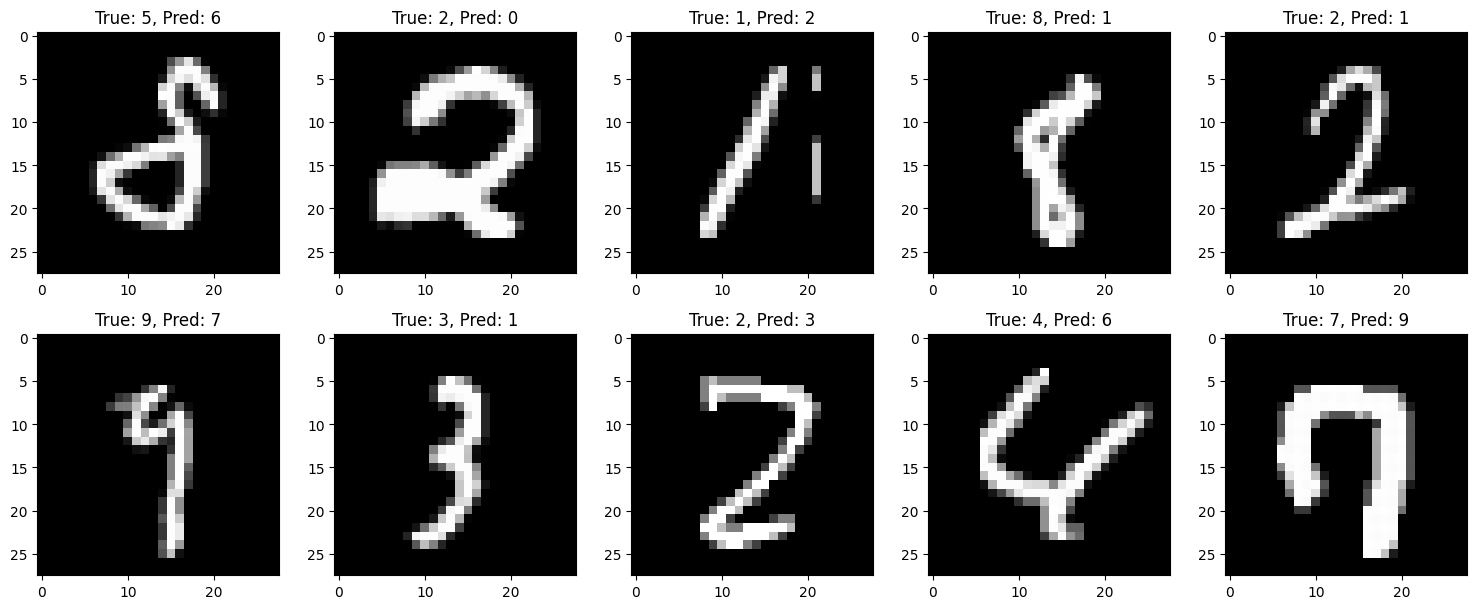

In [12]:
# load params
params = load_params('../assets/mnist_params.pkl')

# get predictions
batched_forward = vmap(forward, in_axes=(None, 0, None))
logits = batched_forward(params, x_test, 'relu')
preds = jnp.argmax(logits, axis=1)

test_acc, test_loss = evaluate_model(params, x_test, y_test, 'relu', classification=True)
print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# get misclassified images
misclassified = jnp.where(preds != y_test)[0]

print(f"We have {len(misclassified)} misclassified images")

# plot misclassified images with correct and predicted labels
num_figures = 10
rows = 4
cols = 5  # rows * cols should be >= num_figures

plt.figure(figsize=(cols * 3, rows * 3))
for i in range(num_figures):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_test[misclassified[i]].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[misclassified[i]]}, Pred: {preds[misclassified[i]]}")
plt.tight_layout()
plt.show()


Next, test the performance of your neural network implementation on a simple regression problem. Fit functions of the form

$$f_k(x) := \sin(k\pi x), \quad x \in [-1, 1],$$

with $k \in \mathbb{N}$ using your neural network implementation. Use mean squared error (MSE) as the loss. Generate a sufficient number of training samples yourself, balancing approximation quality and computational cost.


(a) Perform a grid search to find the best hyperparameters for fitting $f_1$, varying at least the parameters that you also tested in Question 2. Discuss your findings.



In [13]:
# Grid search configurations for regression
grid_search_configs = {
    'architectures': [
        # hidden layers
        [1, 16, 1],
        [1, 16, 16, 1],
        [1, 16, 16, 16, 1],
    ],
    
    # Activation functions
    'activations': ['relu', 'tanh'],
    
    # Learning rates
    'learning_rates': [0.1, 0.01],
    
    # Batch sizes
    'batch_sizes': [64, 128],
    
    # Epochs
    'epochs': [50]
}

In [14]:
# We start by generating training samples.
n_samples = 5000
k = 1
x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
y = jnp.sin(k * jnp.pi * x)

key = random.PRNGKey(42)
indices = jnp.arange(n_samples)
shuffled_indices = random.permutation(key, indices)
x_shuffled = x[shuffled_indices]
y_shuffled = y[shuffled_indices]

x_train, y_train, x_test, y_test = get_splits(x_shuffled, y_shuffled, classification=False)

# sort the x_test and y_test to plot
sort_idx = jnp.argsort(x_test.flatten())
x_test = x_test[sort_idx]
y_test = y_test[sort_idx]

In [15]:
# We do the same grid search as in Question 2.
# best_config, best_acc, best_loss = grid_search(
#     x_train, y_train, 
#     grid_search_configs, 
#     k=3,
#     classification=False
# )

# print("The best configuration is:")
# print(best_config)
# print(f"Best K-fold Mean Accuracy: {best_acc:.2f} ({best_acc*100:.2f}%)")
# print(f"Best K-fold Mean Loss: {best_loss:.2f}")

In [16]:
# We now train the best model on the full training set.
best_config = {
    'layer_widths': [1, 16, 16, 16, 1],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 64,
    'epochs': 50
}

# params, test_acc, test_loss, learning_curve = train_model(
#     x_train, y_train, x_test, y_test, best_config, classification=False
# )

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_loss'], label='Training MSE Loss')
# plt.plot(learning_curve['test_loss'], label='Test MSE Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# save_params(params, filename=f'../assets/{k}_reg_params.pkl')

Parameters loaded from ../assets/1_reg_params.pkl


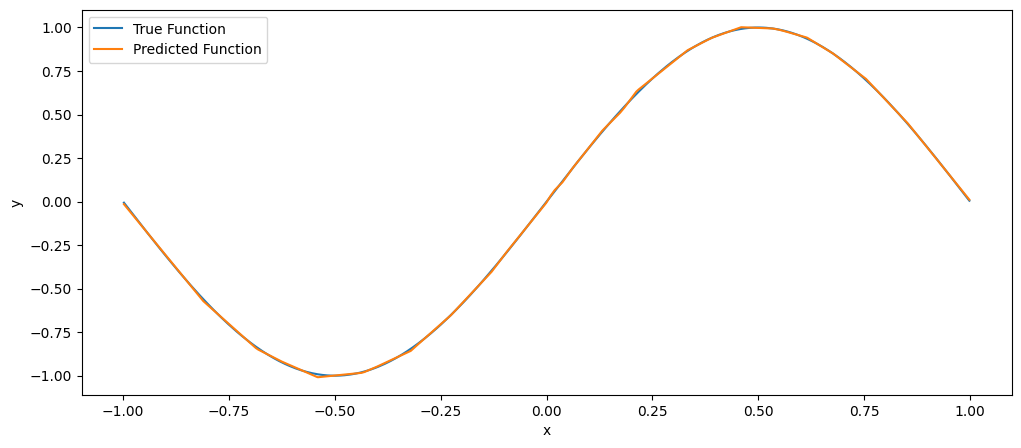

In [17]:
# plot the true function and the predicted function
params = load_params(f'../assets/{k}_reg_params.pkl')

y_pred = forward(params, x_test, best_config['activation'])
plt.figure(figsize=(12, 5))
plt.plot(x_test, y_test, label='True Function')
plt.plot(x_test, y_pred, label='Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

(b) Try to fit $f_k$ for different values of $k$. How do you need to change the hyperparameters when increasing $k$? Discuss your findings. How far can you increase $k$?



In [18]:
def analyze_k_impact(k_values):
    """
    Runs grid search for different values of k to determine optimal hyperparameters.
    """

    # Store best params for each k
    heuristics = {}
    
    for k in k_values:
        print(f"Analyzing k = {k}")
        
        # Generate Data for this specific k
        n_samples = 20000
        x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
        y = jnp.sin(k * jnp.pi * x)
        
        key = random.PRNGKey(k)
        perm = random.permutation(key, n_samples)
        x_shuffled, y_shuffled = x[perm], y[perm]
        
        x_train, y_train, x_test, y_test = get_splits(
            x_shuffled, y_shuffled, train=0.8, classification=False
        )
        
        # Run Grid Search
        # We use k=3 folds to save time, but get reliable results
        best_cfg, best_acc, best_loss = grid_search(
            x_train, y_train, 
            grid_search_configs, 
            k=3, 
            classification=False
        )
        
        heuristics[k] = {
            'config': best_cfg,
            'loss': best_loss
        }

    return heuristics

# We test low, medium, and high frequencies
# k_list = [5, 10, 20, 100]
# k_heuristics = analyze_k_impact(k_list)
# print(k_heuristics)

The problem is hinting at the spectral bias of neural networks: neural network fit lower frequencies better than higher frequencies.

(c) Finally, propose an approach to approximate $f_k$ with higher values of $k$ and test it. Examples could include different function spaces than neural networks, architectural tweaks, activation changes, initialization strategies, or training approaches. Motivate your choice and discuss your findings.

Parameters loaded from ../assets/30_reg_params.pkl


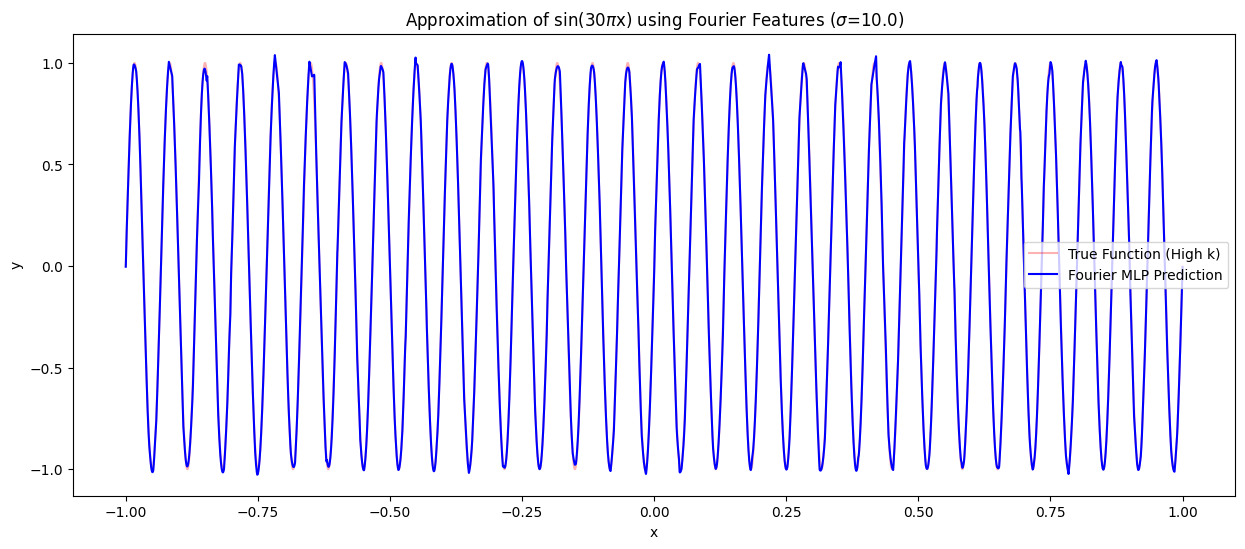

In [26]:
# The Fourier Feature Mapping function
def input_mapping(x, B):
    """
    Maps input x (shape: [N, 1]) to Fourier features.
    """
    if B is None:
        return x
    xp = 2 * jnp.pi * (x @ B)
    
    return jnp.concatenate([jnp.cos(xp), jnp.sin(xp)], axis=-1)

k_high = 30
n_samples = 5000
x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
y = jnp.sin(k_high * jnp.pi * x)

# mapping_size is half the width of the input layer
mapping_size = 128
scale = 10.0 # Sigma: Controls the frequency bandwidth
key = random.PRNGKey(42)
B = random.normal(key, (1, mapping_size)) * scale
params = None

x_mapped = input_mapping(x, B)
indices = jnp.arange(n_samples)
shuffled_indices = random.permutation(key, indices)
x_shuffled = x_mapped[shuffled_indices]
y_shuffled = y[shuffled_indices]
x_train, y_train, x_test, y_test = get_splits(x_shuffled, y_shuffled, classification=False)

input_dim = mapping_size * 2

best_config = {
    'layer_widths': [input_dim, 8, 8, 1],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 64,
    'epochs': 100
}

x_plot = jnp.linspace(-1, 1, 10000).reshape(-1, 1)
x_plot_mapped = input_mapping(x_plot, B)

# print(f"Training on f_{k_high} with Fourier Features...")
# params, test_acc, test_loss, learning_curve = train_model(
#     x_train, y_train, x_test, y_test, best_config, classification=False
# )
# save_params(params, filename=f'../assets/{k_high}_reg_params.pkl')

params = load_params(f'../assets/{k_high}_reg_params.pkl') if params is None else params
y_pred = forward(params, x_plot_mapped, best_config['activation'])

plt.figure(figsize=(15, 6))
plt.plot(x, y, color='red', alpha=0.3, label='True Function (High k)')
plt.plot(x_plot, y_pred, color='blue', label='Fourier MLP Prediction')
plt.title(f"Approximation of sin({k_high}$\pi$x) using Fourier Features ($\sigma$={scale})")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_loss'], label='Train Loss')
# plt.plot(learning_curve['test_loss'], label='Test Loss')
# plt.yscale('log')
# plt.title('Loss Curve (Log Scale)')
# plt.legend()
# plt.show()